This is just to demonstrate how the analysis will work for the POC, and also to show what the final exported notebook will look like. When that is implemented, get rid of this!

First, generate a fake dataset. In the future, let's check it in and use it if the [`--demo` flag](https://github.com/opendp/dp-creator-ii/issues/7) is given.

In [1]:
import csv
import random

random.seed(0) # So the mock data will be stable across runs.

def clip(n, lower, upper):
    return max(min(n, upper), lower)

csv_path = '/tmp/demo.csv'

with open(csv_path, 'w', newline='') as demo_handle:
    fields = ['student_id', 'class_year', 'hw_number', 'grade']
    writer = csv.DictWriter(demo_handle, fieldnames=fields)
    writer.writeheader()
    for student_id in range(1, 100):
        class_year = int(clip(random.gauss(2, 1), 1, 4))
        mean_grade = random.gauss(80, 5) + class_year * 2
        for hw_number in range(1, 10):
            grade = int(clip(random.gauss(mean_grade, 5), 0, 100))
            writer.writerow({
                'student_id': student_id,
                'class_year': class_year,
                'hw_number': hw_number,
                'grade': grade,
            })

Sanity check:

In [2]:
import polars

lf = polars.scan_csv(csv_path)
lf.collect()

student_id,class_year,hw_number,grade
i64,i64,i64,i64
1,2,1,73
1,2,2,78
1,2,3,71
1,2,4,76
1,2,5,77
…,…,…,…
99,2,5,78
99,2,6,74
99,2,7,75


TODO: Plot function from in https://github.com/opendp/dp-creator-ii/pull/35... but see farther down in the notebook: This can probably be further simplified.

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def plot_error_bars_with_cutoff(
    y_values, x_min_label="min", x_max_label="max", y_cutoff=0, y_error=0
):
    x_values = 0.5 + np.arange(len(y_values))
    x_values_above = []
    x_values_below = []
    y_values_above = []
    y_values_below = []
    for x, y in zip(x_values, y_values):
        if y < y_cutoff:
            x_values_below.append(x)
            y_values_below.append(y)
        else:
            x_values_above.append(x)
            y_values_above.append(y)

    figure, axes = plt.subplots()
    color = "skyblue"
    shared = {
        "width": 0.8,
        "edgecolor": color,
        "linewidth": 1,
        "yerr": y_error,
    }
    axes.bar(x_values_above, y_values_above, color=color, **shared)
    axes.bar(x_values_below, y_values_below, color="white", **shared)
    axes.hlines([y_cutoff], 0, len(y_values), colors=["black"], linestyles=["dotted"])

    axes.set(xlim=(0, len(y_values)), ylim=(0, max(y_values)))
    axes.get_xaxis().set_ticks(
        ticks=[x_values[0], x_values[-1]],
        labels=[x_min_label, x_max_label],
    )
    axes.get_yaxis().set_ticks([])

In [4]:
class_years = lf.group_by('class_year').len().collect().sort('class_year')
class_years

class_year,len
i64,u32
1,414
2,297
3,126
4,54


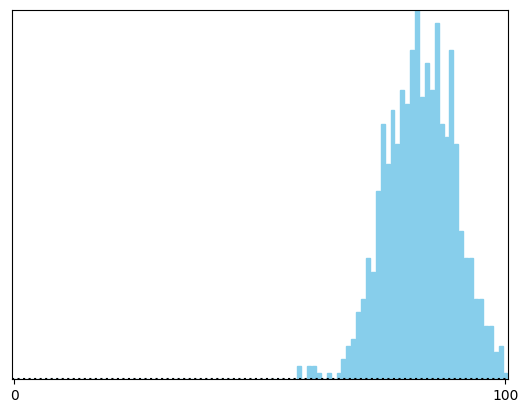

In [5]:
grades = lf.group_by('grade').len().collect().sort('grade')
min_grade = 0
max_grade = 100
df_0_100 = polars.from_dict({'grade': range(min_grade, max_grade+1)})
grades_0_100 = df_0_100.join(grades, on='grade', how='left').select(['len']).fill_null(0)
plot_error_bars_with_cutoff(grades_0_100.to_series().to_list(), min_grade, max_grade)

## _Proposed generated notebook starts below!_

---

# Introduction to Differential Privacy with OpenDP

This notebook demonstrates how to make a differentially private release with [OpenDP](https://docs.opendp.org) using the data you've provided. The OpenDP programming interface has many more options than we can expose in a web interface, and this notebook will suggest some options to explore.

Differential privacy quantifies how much privacy is lost when answering/releasing queries about a sensitive dataset. Quoting Dwork and Roth, "giving overly accurate answers to too many questions will inevitably destroy privacy." With this in mind, it is customary to set what is called a "privacy budget" that limits the number and accuracy of queries. In practice, this means you need to be careful how you spend your privacy budget, because you won't be able to release queries that will cause you to exceed your privacy budget.
Interactively developing DP analyses is a good practice, for example, to identify variables of interest before choosing where to spend the rest of a finite privacy budget. That said, it is important to track the total budget consumed: It would not be good to run a cell in this notebook, look at output, and then run it again, without tracking the privacy consumed by each operation.

We begin with a conventional set of imports:

In [6]:
# Uncomment if you have not already installed OpenDP:
# %pip install opendp[polars]==0.11.1

# OpenDP extends the Polars dataframe library:
import polars as pl
# Conventional import for OpenDP:
import opendp.prelude as dp

# OpenDP plans to offer a set algorithms that have been formally reviewed for correctness.
# Until that is complete, we need to opt-in to "contributed" features:
dp.enable_features("contrib")

Next, the information that was provided in the UI:

In [7]:
# Information you've provided that applies to the whole calculation:
# Data:
csv_path = '/tmp/demo.csv'
max_possible_rows = 1000000 
# Privacy unit:
contributions = 10
# Privacy loss:
epsilon = 2
weights = [4, 4, 1, 1]
delta = 1e-7
# Accuracy:
alpha = 0.05

# Public information you've provided for the "grade" column:
grade_min = 50
grade_max = 100
grade_bins_count = 10

# Public information you've provided for the "class_year" column:
class_year_min = 1
class_year_max = 4
class_year_bins_count = 4

In [8]:
# From the public information, determine the bins:
grade_bins_list = list(range(
    grade_min,
    grade_max,
    int((grade_max - grade_min + 1) / grade_bins_count)
))
class_year_bins_list = list(range(
    class_year_min,
    class_year_max,
    int((class_year_max - class_year_min + 1) / class_year_bins_count)
))

Finally, define a [`Context`](https://docs.opendp.org/en/stable/api/user-guide/context/index.html) using the provided information.

In [9]:
context = dp.Context.compositor(
    data=pl.scan_csv(csv_path, encoding="utf8-lossy").with_columns(
        # The cut() method returns a Polars categorical type.
        # Cast to string to get the human-readable label.
        pl.col("grade").cut(grade_bins_list).alias("grade_bin").cast(pl.String),
        pl.col("class_year").cut(class_year_bins_list).alias("class_year_bin").cast(pl.String)
    ),
    privacy_unit=dp.unit_of(contributions=contributions),
    privacy_loss=dp.loss_of(epsilon=epsilon, delta=delta),
    split_by_weights=weights,
    margins={
        (): dp.polars.Margin(
            max_partition_length=max_possible_rows,
            # To calculate the mean, we need to know the total number of entries,
            # but this is not by default public information. We must opt-in:
            public_info="lengths",
        ),
        ("grade_bin",): dp.polars.Margin(
            max_partition_length=max_possible_rows,
            public_info="keys",
        ),
        ("class_year_bin",): dp.polars.Margin(
            max_partition_length=max_possible_rows,
            public_info="keys",
        ),

    },
)

(A note on `utf8-lossy`: CSVs can use different "character encodings" to represent characters outside the plain ASCII character set, but out of the box the Polars library only supports UTF8. Specifying `utf8-lossy` preserves as much information as possible, and any unrecognized characters will be replaced by "�". If this is not sufficient, you will need to preprocess your data to reencode it as UTF8.)

Before making the DP release, let's define helper functions to render the histograms.

In [10]:
def df_to_dict(df):
    return {
        # The name of the key will vary, so just get the first value.
        list(range_len.values())[0]: range_len['len']
        for range_len in df.to_dicts()
    }

import matplotlib.pyplot as plt

def plot_histogram(histogram_df, error, cutoff):
    histogram_dict = df_to_dict(histogram_df)
    labels, values = zip(*histogram_dict.items())
    _figure, axes = plt.subplots()
    axes.bar(labels, values, color=['blue' if v > cutoff else 'lightblue' for v in values], yerr=error)
    axes.axhline(cutoff, color="lightgrey", zorder=-1)

## `grade` stats

### DP Mean

In [11]:
grade_mean_query = context.query().select(
    pl.col("grade").fill_null(0).dp.mean(bounds=(grade_min, grade_max))
)
grade_mean_summary = grade_mean_query.summarize()
grade_mean_summary

column,aggregate,distribution,scale
str,str,str,f64
"""grade""","""Sum""","""Integer Laplace""",500.0
"""grade""","""Len""",null,null


In [12]:
grade_mean = grade_mean_query.release().collect()
grade_mean

grade
f64
84.251403


### DP Histogram

In [13]:
grade_histogram_query = (context.query()
        .group_by("grade_bin")
        .agg(pl.len().dp.noise()))
grade_histogram_95_accuracy = grade_histogram_query.summarize(alpha=alpha)["accuracy"].item()
grade_histogram_95_accuracy

60.40839612201301

In [14]:
grade_histogram = (grade_histogram_query
        .release()
        .collect()
        .sort("grade_bin")
)
grade_histogram

grade_bin,len
str,u32
"""(55, 60]""",24
"""(60, 65]""",0
"""(65, 70]""",28
"""(70, 75]""",181
"""(75, 80]""",227
"""(80, 85]""",248
"""(85, 90]""",204
"""(90, 95]""",110
"""(95, inf]""",0


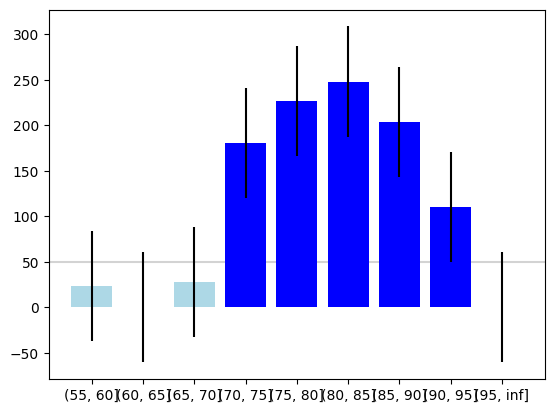

In [15]:
plot_histogram(grade_histogram, error=grade_histogram_95_accuracy, cutoff=50) # TODO: Set cutoff correctly.

## `class_year` stats

### DP Mean

In [16]:
class_year_mean = context.query().select(
    pl.col("class_year").fill_null(0).dp.mean(bounds=(class_year_min, class_year_max))
).release().collect()
class_year_mean

class_year
f64
1.81257


### DP Histogram

In [17]:
class_year_histogram_query = (context.query()
        .group_by("class_year_bin")
        .agg(pl.len().dp.noise()))
class_year_histogram_95_accuracy = class_year_histogram_query.summarize(alpha=alpha)["accuracy"].item()
class_year_histogram_95_accuracy

60.40839612201301

In [18]:
class_year_histogram = (class_year_histogram_query
        .release()
        .collect()
        .sort("class_year_bin")
)
class_year_histogram

class_year_bin,len
str,u32
"""(-inf, 1]""",420
"""(1, 2]""",311
"""(2, 3]""",80
"""(3, inf]""",47


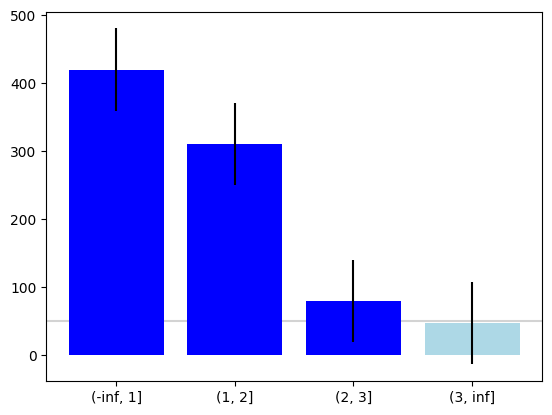

In [19]:
plot_histogram(class_year_histogram, error=class_year_histogram_95_accuracy, cutoff=50) # TODO: Set cutoff correctly.

At this point, the privacy budget of the context, configured at the start with `epsilon` and `weights`, is exhausted: attempting to make another release will result in an error.

---

# Other exports

Below is a proposal for what the other export formats (text and CSV) would look like. We first make a data structure with everything we need, and then use generic methods to serialize that structure.

In [20]:
release = {
    'inputs': {
        'csv_path': csv_path,
        'contributions': contributions,
        'epsilon': epsilon,
        'weights': weights,
        'max_possible_rows': max_possible_rows,
        'delta': delta,
        'grade': {
            'min': grade_min,
            'max': grade_max,
            'bins_count': grade_bins_count,
        },
        'class_year': {
            'min': class_year_min,
            'max': class_year_max,
            'bins_count': class_year_bins_count,
        }    
    },
    'outputs': {
        'grade': {
            'mean': grade_mean.item(),
            'histogram': {v['grade_bin']: v['len'] for v in grade_histogram.to_dicts()}
        },
        'class_year': {
            'mean': class_year_mean.item(),
            'histogram': {v['class_year_bin']: v['len'] for v in class_year_histogram.to_dicts()}
        },
    }
}
release

{'inputs': {'csv_path': '/tmp/demo.csv',
  'contributions': 10,
  'epsilon': 2,
  'weights': [4, 4, 1, 1],
  'max_possible_rows': 1000000,
  'delta': 1e-07,
  'grade': {'min': 50, 'max': 100, 'bins_count': 10},
  'class_year': {'min': 1, 'max': 4, 'bins_count': 4}},
 'outputs': {'grade': {'mean': 84.25140291806959,
   'histogram': {'(55, 60]': 24,
    '(60, 65]': 0,
    '(65, 70]': 28,
    '(70, 75]': 181,
    '(75, 80]': 227,
    '(80, 85]': 248,
    '(85, 90]': 204,
    '(90, 95]': 110,
    '(95, inf]': 0}},
  'class_year': {'mean': 1.8125701459034793,
   'histogram': {'(-inf, 1]': 420,
    '(1, 2]': 311,
    '(2, 3]': 80,
    '(3, inf]': 47}}}}

### Text export?

Just use YAML, unless there are other requirements?

In [21]:
import yaml

print(yaml.dump(release))

inputs:
  class_year:
    bins_count: 4
    max: 4
    min: 1
  contributions: 10
  csv_path: /tmp/demo.csv
  delta: 1.0e-07
  epsilon: 2
  grade:
    bins_count: 10
    max: 100
    min: 50
  max_possible_rows: 1000000
  weights:
  - 4
  - 4
  - 1
  - 1
outputs:
  class_year:
    histogram:
      (-inf, 1]: 420
      (1, 2]: 311
      (2, 3]: 80
      (3, inf]: 47
    mean: 1.8125701459034793
  grade:
    histogram:
      (55, 60]: 24
      (60, 65]: 0
      (65, 70]: 28
      (70, 75]: 181
      (75, 80]: 227
      (80, 85]: 248
      (85, 90]: 204
      (90, 95]: 110
      (95, inf]: 0
    mean: 84.25140291806959



### CSV export?

Flatten the data stucture to key value pairs and make a two-column CSV unless there are other requirements?

In [22]:
from pandas import json_normalize

json_normalize(release).transpose()

,0
inputs.csv_path,/tmp/demo.csv
inputs.contributions,10
inputs.epsilon,2
inputs.weights,"[4, 4, 1, 1]"
inputs.max_possible_rows,1000000
inputs.delta,0.0
inputs.grade.min,50
inputs.grade.max,100
inputs.grade.bins_count,10
inputs.class_year.min,1
